# (28) Fit: Iterative P-VAE

**Motivation**: Fit The first ```IPVAE```. host = ```solo```, device = ```cuda:0``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_IterativeVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [49]:
# HIDE CODE


from analysis.loggabor import fit_loggabor
from figures.imgs import plot_weights, make_grid
from figures.theta import plot_theta


def fit_norm(data):
    rv = sp_stats.norm(*sp_stats.norm.fit(data))
    ks_test = sp_stats.kstest(
        rvs=data,
        cdf='norm',
        args=(rv.mean(), rv.std()),
    )
    return rv, ks_test


def plot_kl_log_rates(dead_thres = None, time_idx: int = -1):
    fig, axes = create_figure(1, 3, (10, 2), width_ratios=[2, 1.5, 1.5])
    
    # plot kl
    bins = np.linspace(0, 185, 186)
    sns.histplot(kl_diag[time_idx, ~dead] * 1000, bins=bins, stat='count', color='dimgrey', label='alive', ax=axes[0])
    sns.histplot(kl_diag[time_idx, dead] * 1000, bins=bins, stat='count', color='r', label='dead', ax=axes[0])
    if dead_thres is not None:
        axes[0].axvline(dead_thres * 1000, color='r', ls='--', alpha=0.6)
    axes[0].locator_params(axis='x', nbins=7)
    axes[0].set_title('kl_diag')
    
    # fit log normal
    rv, ks_test = fit_norm(log_prior_rate[~dead])
    xs = np.linspace(
        start=rv.ppf(1e-5),
        stop=rv.ppf(1 - 1e-5),
        num=10000,
    )
    pdf = rv.pdf(xs)

    # plot prior rates + log normal fit
    sns.histplot(log_prior_rate[~dead], stat='density', color=sns.color_palette('muted')[0], label=r'$\log r$', ax=axes[1])
    axes[1].plot(xs, pdf, color='r', lw=2, ls='--', label=f'fit (p={ks_test.pvalue:1.1g})')
    axes[1].locator_params(axis='x', nbins=7)
    axes[1].set_title('log prior rate')
    
    sns.histplot(log_prior_rate[~dead], stat='count', color=sns.color_palette('muted')[0], label='alive', kde=True, ax=axes[2])
    sns.histplot(log_prior_rate[dead], stat='count', color='r', label='dead', kde=True, ax=axes[2])
    axes[2].locator_params(axis='x', nbins=7)
    axes[2].set(title='log prior rate') # , yscale='log')
    
    for ax in axes.flat:
        ax.set(ylabel='')
        ax.legend(fontsize=10)
    plt.show()


def perform_test(key: str = 'prior_rate', log: bool = True):
    # key = 'prior_rate' if tr.model.cfg.fit_prior else 'kl'
    try:
        rates_cardinal = results.loc[(results['label'] == 'cardinal') & ~dead, key].values
        rates_oblique = results.loc[(results['label'] == 'oblique') & ~dead, key].values
        if log:
            rates_cardinal, rates_oblique = map(
                np.log, [rates_cardinal, rates_oblique])
        u_test = sp_stats.mannwhitneyu(rates_cardinal, rates_oblique, method='auto')
        t_test = sp_stats.ttest_ind(rates_cardinal, rates_oblique, equal_var=True)
        a, b = len(rates_cardinal), len(rates_oblique)
        cardinal_ratio = a / (a+b)
        return u_test, t_test, cardinal_ratio
    except KeyError:
        return

In [3]:
device_idx = 0
device = f'cuda:{device_idx}'

print(f"host: {os.uname().nodename}")

host: solo

## HIP-VAE

In [4]:
model_type = 'poisson'
cfg_vae, cfg_tr = default_configs('vH16', model_type, 'lin|lin')

cfg_vae['init_scale'] = 1e-5
cfg_vae['n_latents'] = 512
cfg_vae['seq_len'] = 10

cfg_vae['norm_phi'] = False
cfg_vae['norm_proj'] = False
cfg_tr['epochs'] = 900

print(f"VAE:\n{cfg_vae}\n\nTrainer:\n{cfg_tr}")

VAE:
{'dataset': 'vH16', 'n_latents': 512, 'prior_clamp': -4, 'fit_prior': True, 'enc_type': 'lin', 'dec_type': 'lin', 
'enc_bias': False, 'dec_bias': False, 'init_dist': 'normal', 'init_scale': 1e-05, 'seq_len': 10, 'norm_phi': False,
'norm_proj': False}

Trainer:
{'lr': 0.005, 'batch_size': 1000, 'epochs': 900, 'optimizer_kws': {'weight_decay': 0.0}, 'grad_clip': 500, 
'kl_const_portion': 0.0}

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|    HIPVAE   |  262.7 K   |
|     ———     |    ———     |
|  layers.L_0 |  262.7 K   |
+-------------+------------+

poisson_uniform_c(-4)_vH16_t-10_z-[512]_fp_nrm-none_<lin|lin>
mc_b1000-ep900-lr(0.005)_beta(1:0x0.5)_temp(0.1:lin-0.5)_gr(500)_(2024_07_29,17:01)

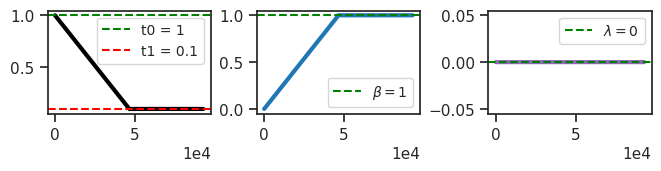

In [5]:
from vae.vae import HIPVAE
vae = HIPVAE(CFG_CLASSES[model_type](**cfg_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

vae.print()
print(f"{vae.cfg.name()}\n{tr.cfg.name()}_({vae.timestamp})\n")
tr.show_schedules()

In [6]:
tr.train()

epoch # 900, avg loss: 67.105088: 100%|█████| 900/900 [7:38:51<00:00, 30.59s/it]


epoch # 900, avg loss: 98.059258: 100%|█████| 900/900 [3:05:57<00:00, 12.40s/it]


In [15]:
data, loss, etc = tr.validate(full_data=True)
kl_diag = loss['kl_diag'][:, -tr.model.cfg.n_latents[-1]:]
loss = {k: v.mean(0) for k, v in loss.items() if k != 'kl_diag'}

print(loss)

{
    'kl': array([62.15936 , 45.458183, 30.000671, 19.592558, 14.444861, 12.076967,
       10.913346, 10.254609,  9.834803,  9.535784], dtype=float32),
    'recon': array([128.78804 ,  81.34842 ,  54.97014 ,  41.529606,  34.48892 ,
        30.51061 ,  28.065754,  26.458244,  25.343012,  24.447096],
      dtype=float32),
    'nelbo': array([190.94742 , 126.80681 ,  84.97067 ,  61.12207 ,  48.93348 ,
        42.587513,  38.97916 ,  36.71271 ,  35.177845,  33.9827  ],
      dtype=float32)
}

{
    'kl': array([58.644672, 40.052326, 24.880669, 16.816677, 13.926625],
      dtype=float32),
    'recon': array([129.18228 ,  80.358986,  57.019016,  46.898003,  41.81558 ],
      dtype=float32),
    'nelbo': array([187.82678 , 120.411766,  81.90012 ,  63.7146  ,  55.74246 ],
      dtype=float32)
}

In [23]:
## Was T = 1

{
    'kl': array([26.464891], dtype=float32),
    'recon': array([147.85541], dtype=float32),
    'nelbo': array([174.3203], dtype=float32)
}

In [9]:
data['x'].shape

(25811, 256)

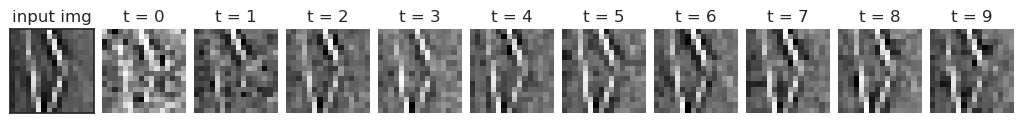

In [10]:
ncols = 1 + tr.model.cfg.seq_len
fig, axes = create_figure(1, ncols, (0.92 * ncols, 1.3), 'all', 'all')

ax = axes[0]
ax.imshow(data['x'][124].reshape(16, 16), cmap='Greys_r')
ax.set_title('input img')

for t in range(tr.model.cfg.seq_len):
    ax = axes[t + 1]
    ax.imshow(data['y'][124, t].reshape(16, 16), cmap='Greys_r')
    ax.set_title(f"t = {t}")
remove_ticks(axes[1:])
ax_square(axes);

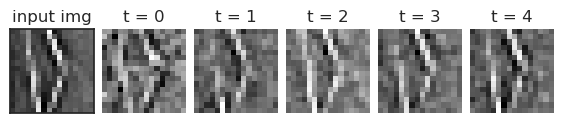

In [16]:
kl_diag.shape

(10, 512)

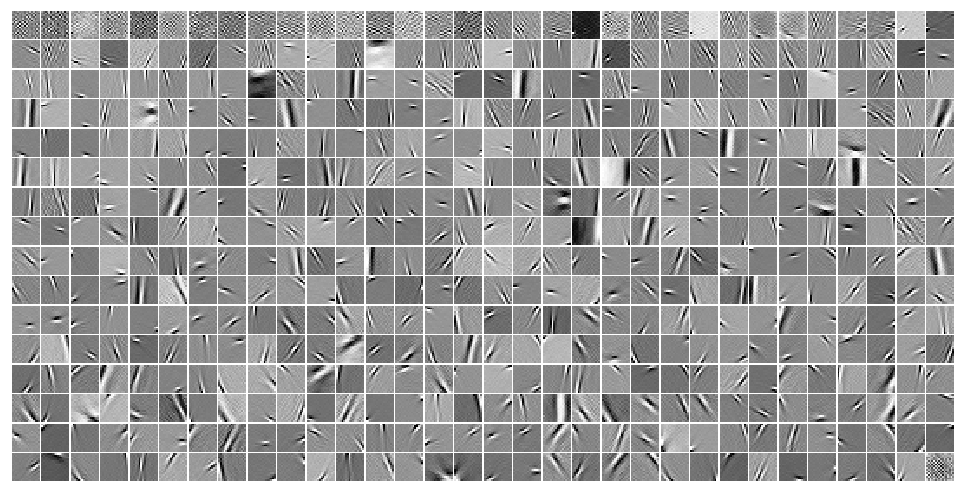

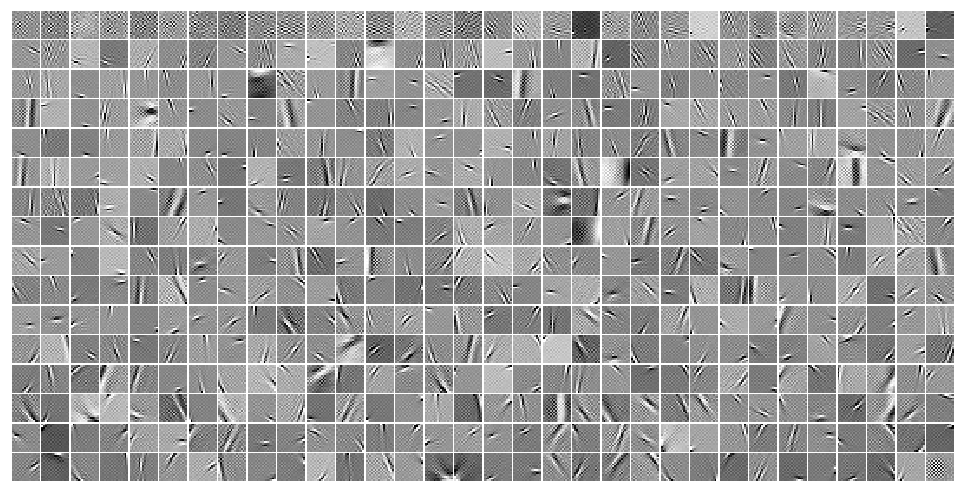

In [28]:
order = np.argsort(kl_diag[-1])
tr.model.show('phi', order=order, dpi=120)
tr.model.show('proj', order=order, dpi=120);

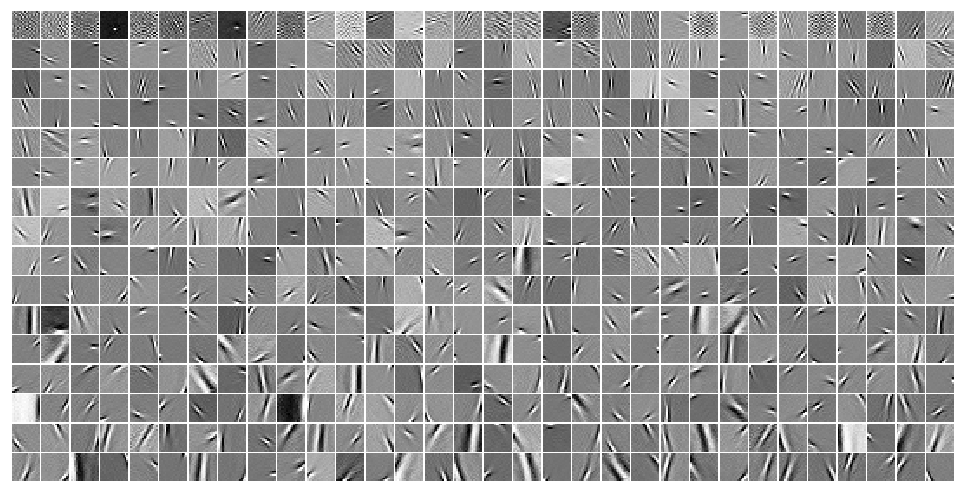

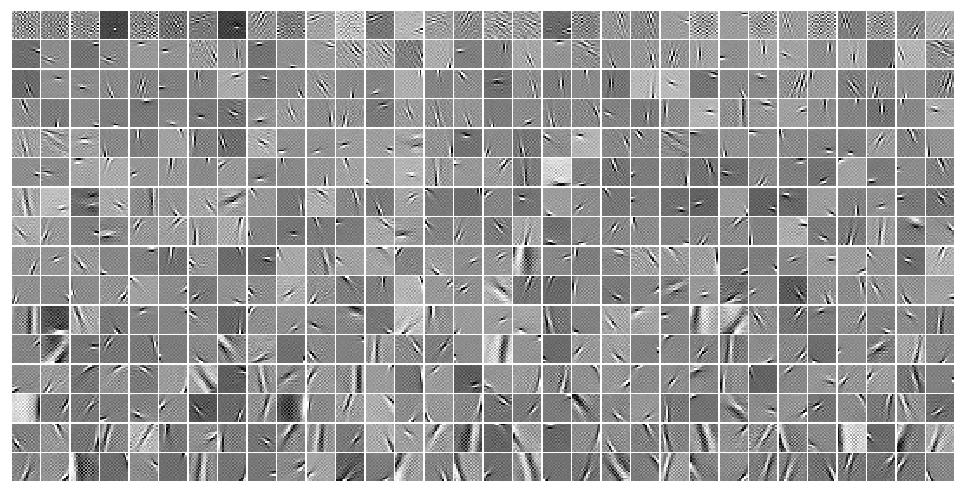

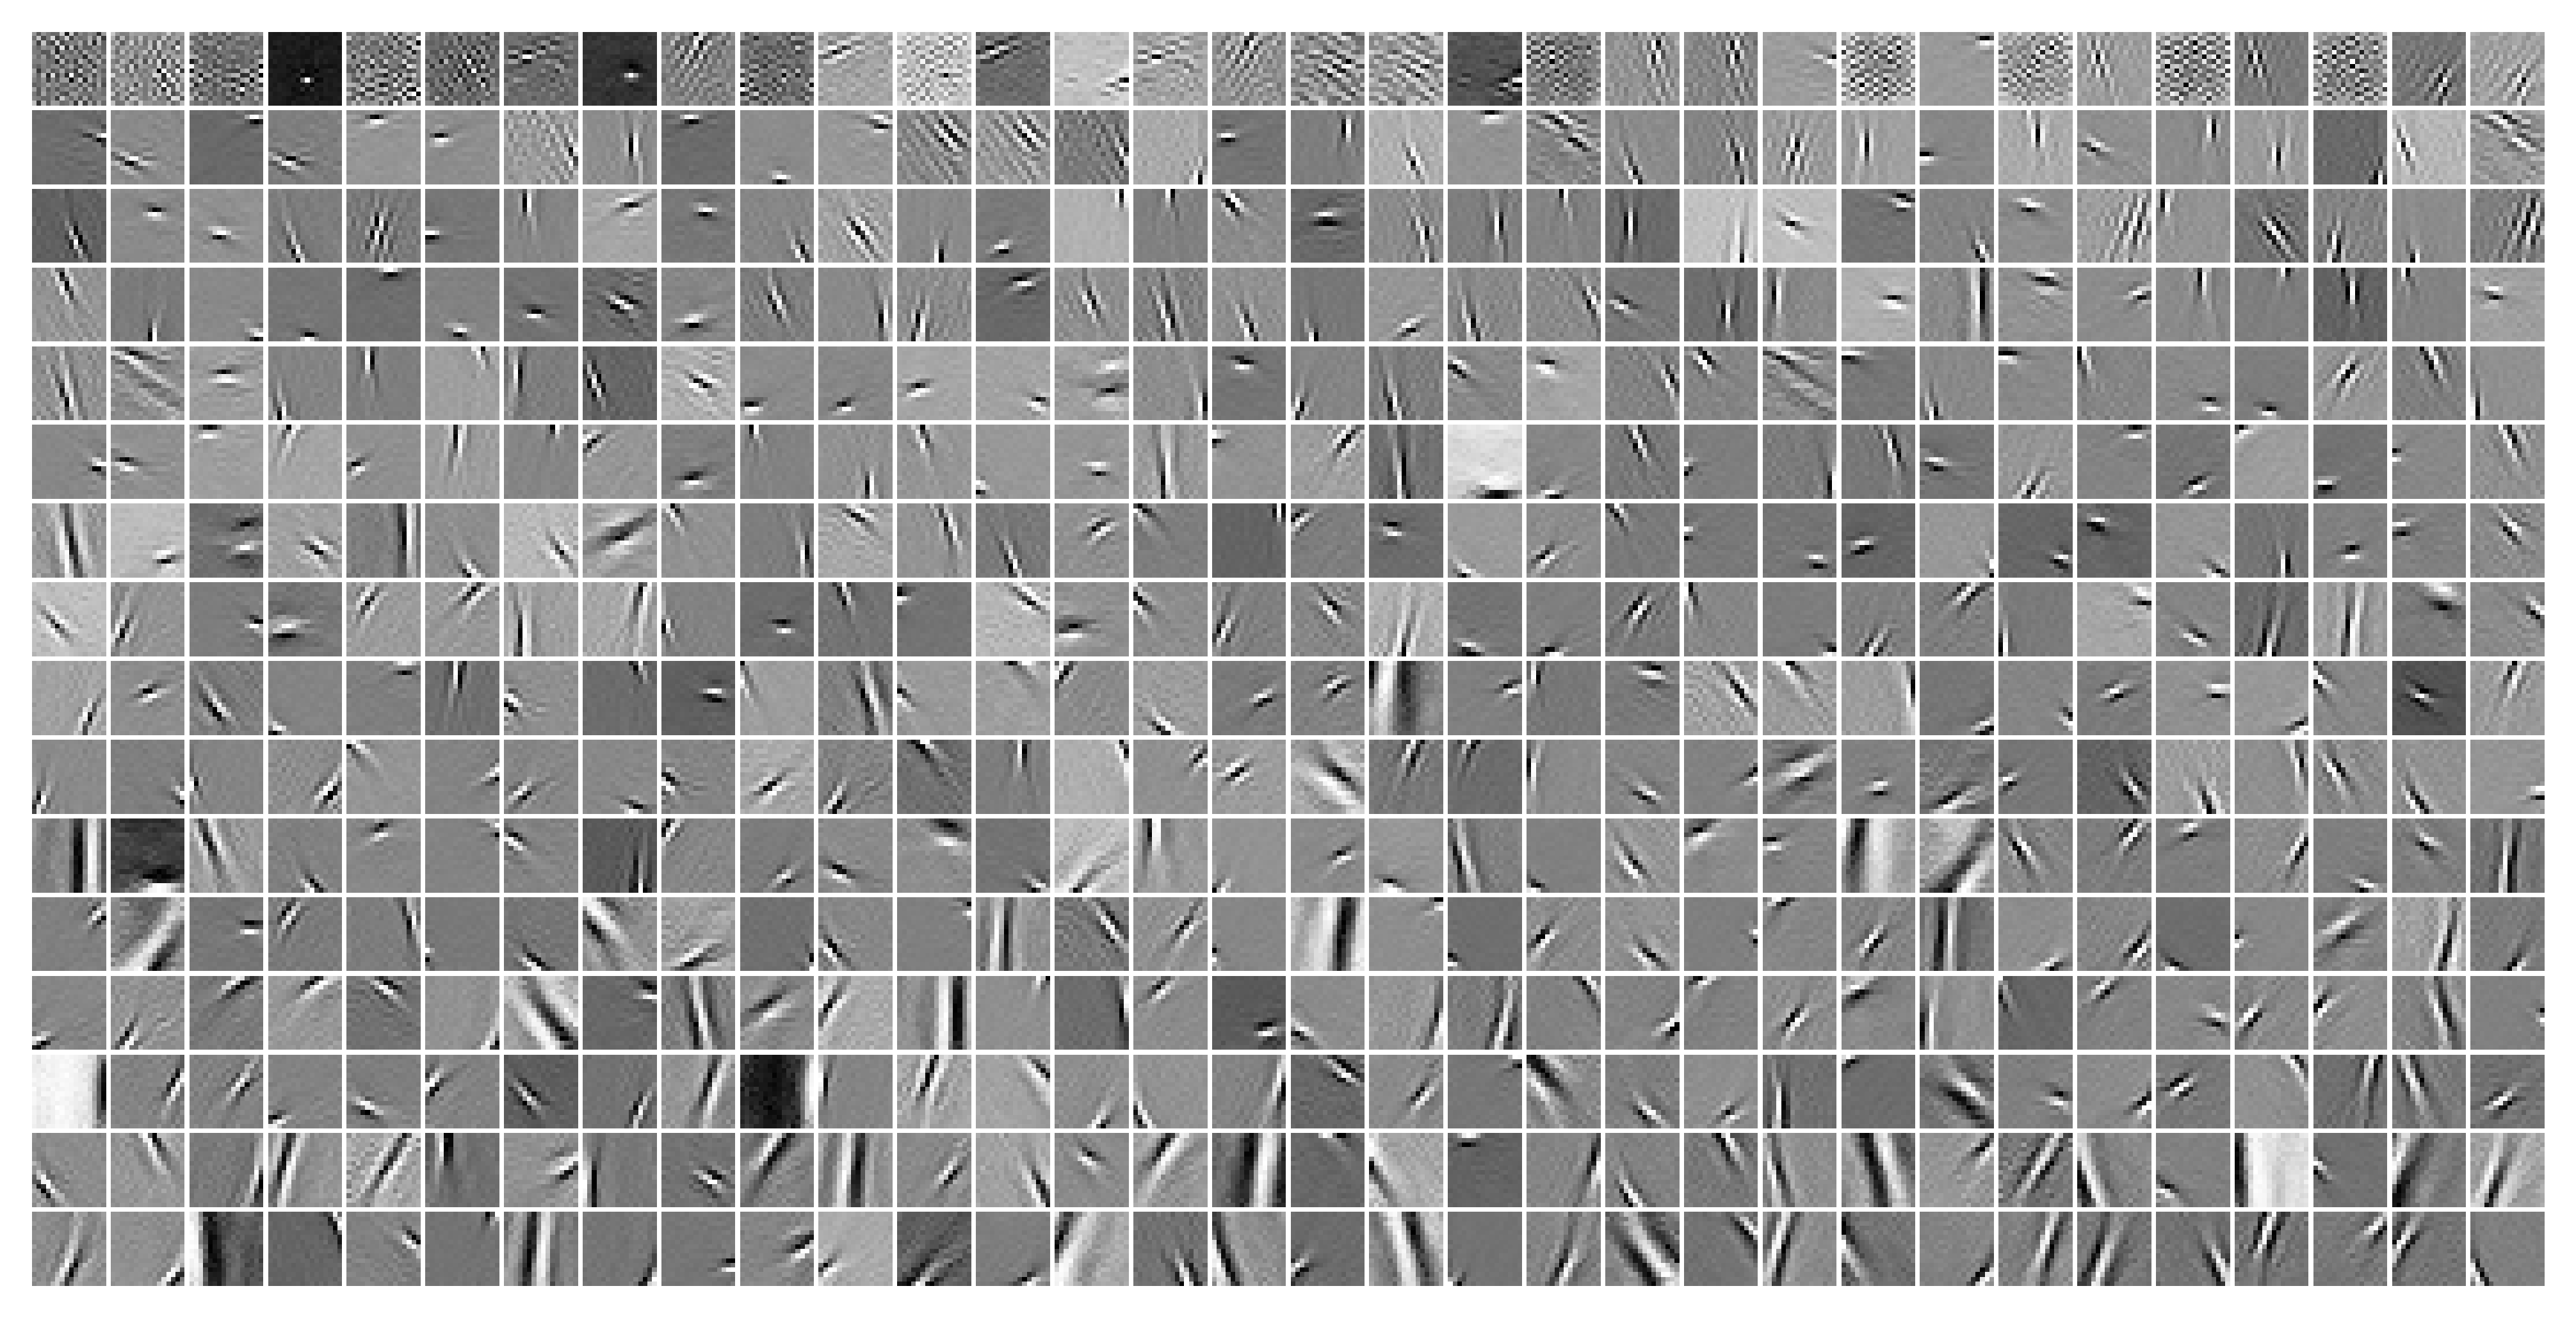

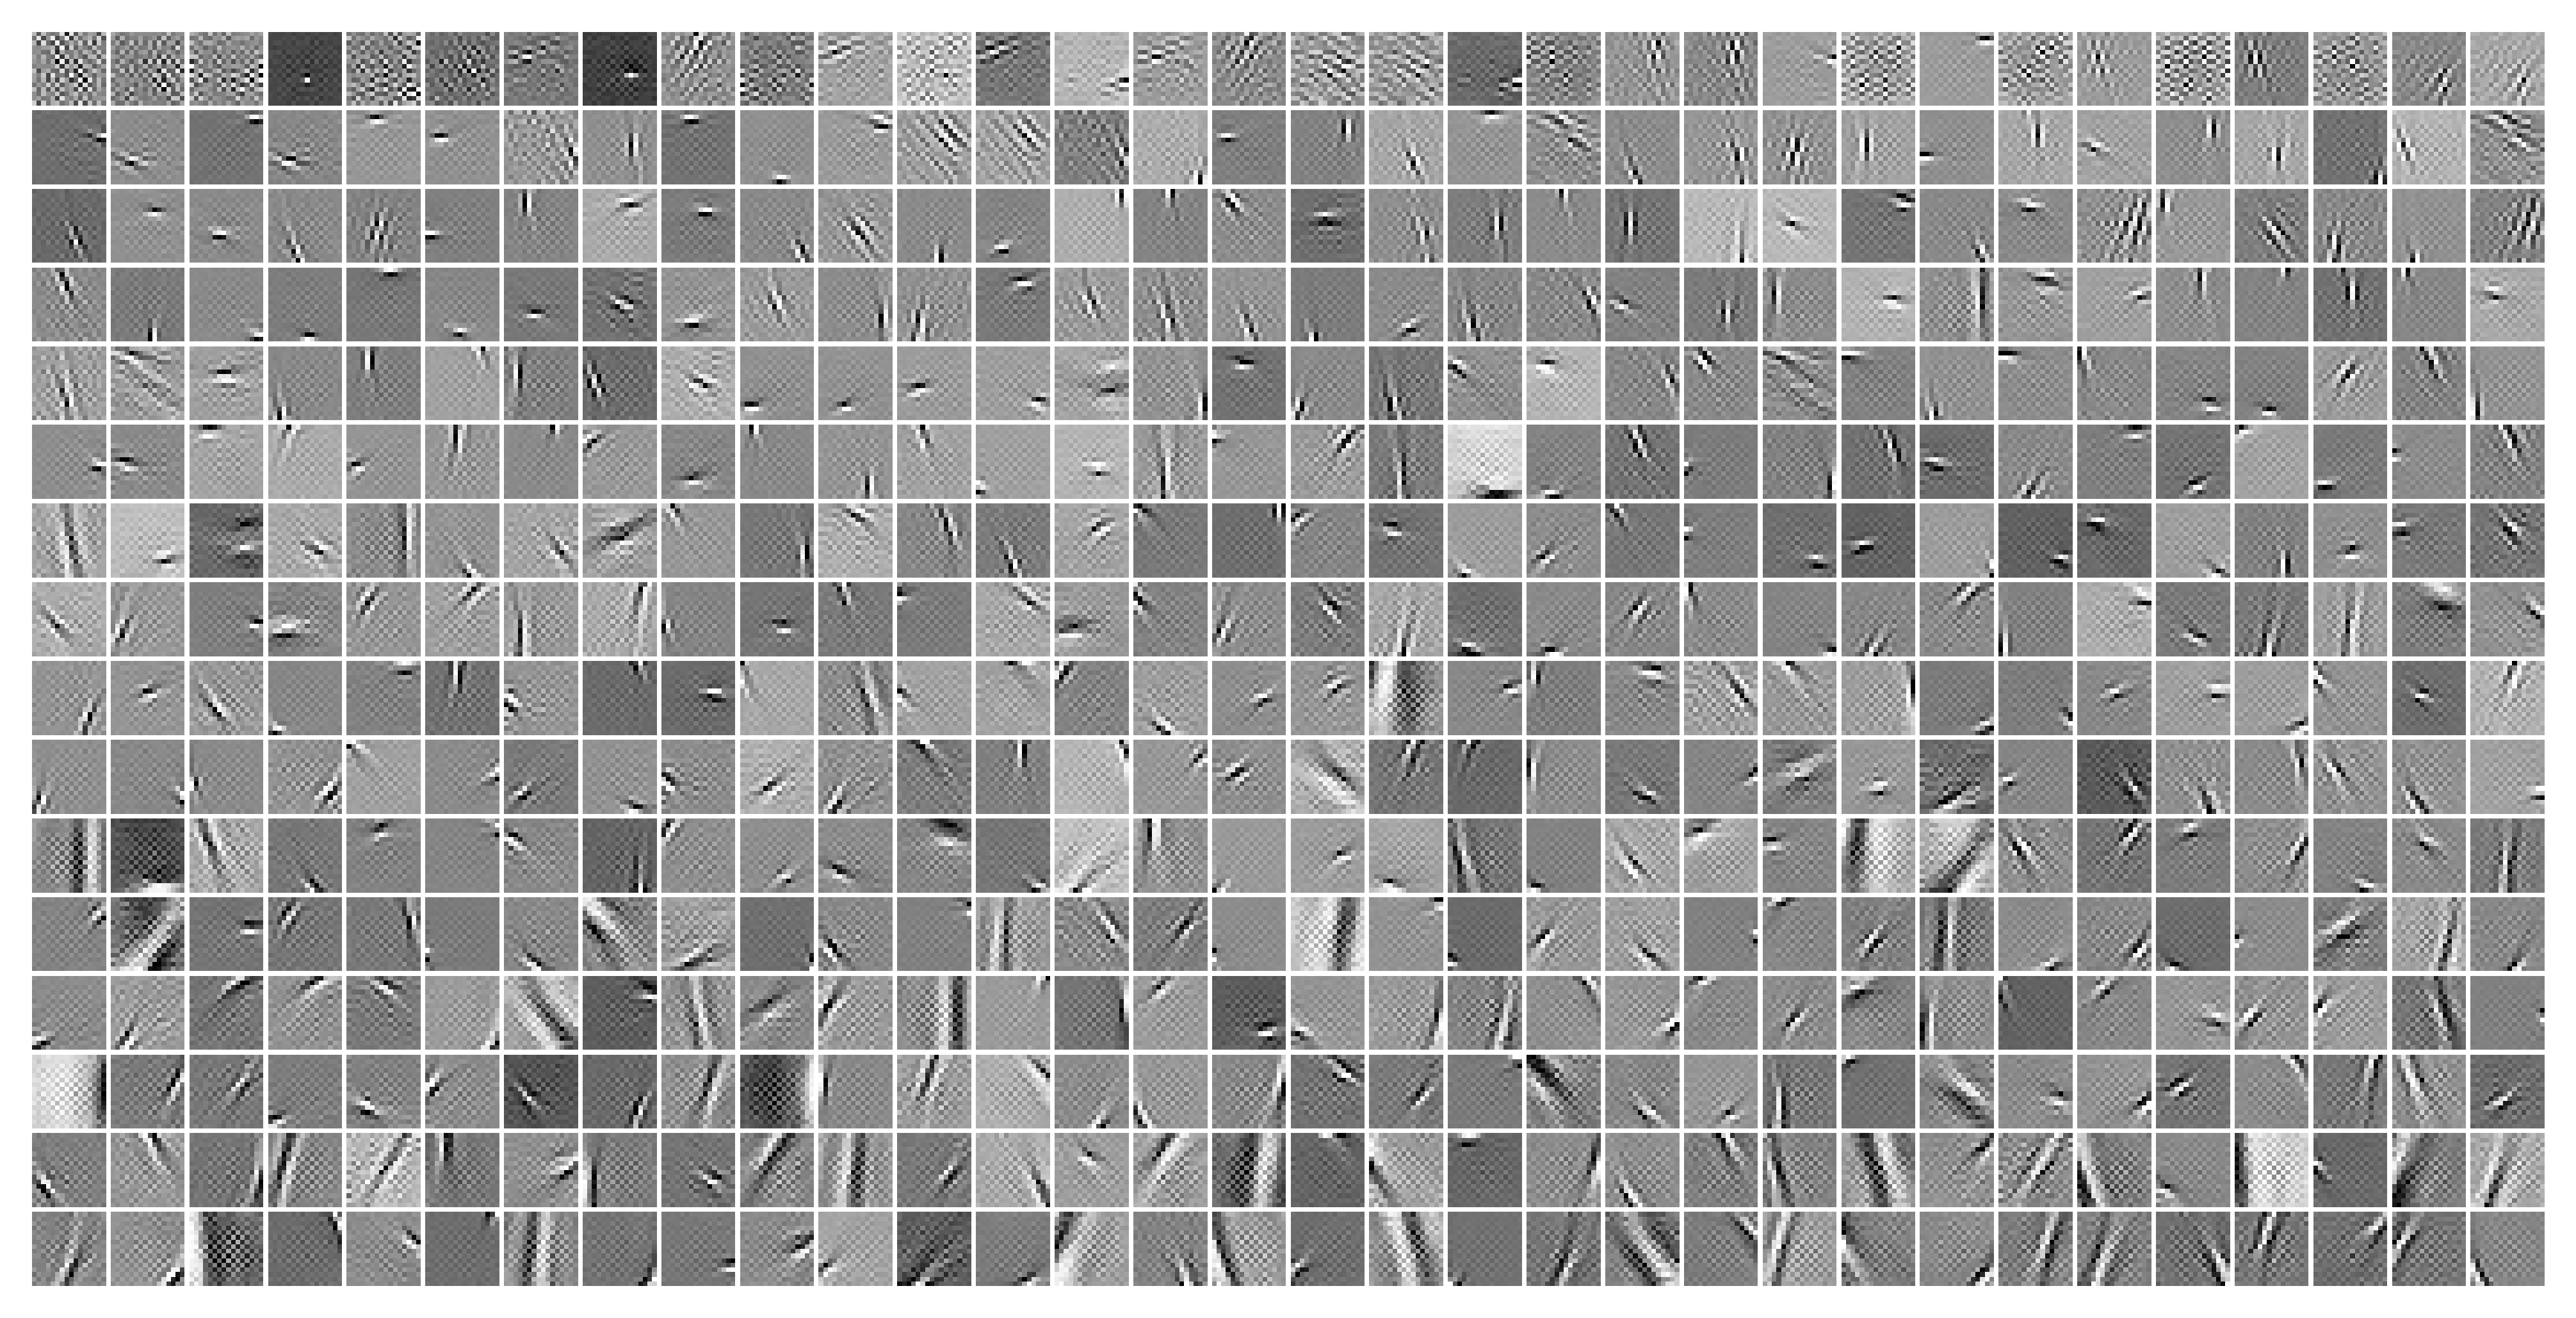

(<Figure size 4000x2000 with 1 Axes>, <Axes: >)

In [177]:
tr.model.show('phi', order=order, dpi=500)
tr.model.show('proj', order=order, dpi=500)

In [29]:
lifetime, population, percents = sparse_score(z=data['z'][:, -1, :], cutoff=0.01)
print(f"lifetime = {lifetime.mean():0.5f}  ———  population = {population.mean():0.5f}\npercents: {percents}")

lifetime = 0.51453  ———  population = 0.51115
percents: {'0': 8.9, '1': 12.9, '2': 13.6, '3': 12.4, '4': 10.5, '5': 8.5, '6': 6.7, '7': 5.2, '8': 4.0, '9': 3.2, 
'10': 2.5, '11': 2.0, '12': 1.6, '13': 1.3, '14': 1.1, '15': 0.9, '16+': 4.9}

In [30]:
for t in range(5):
    lifetime, population, percents = sparse_score(z=data['z'][:, t, :], cutoff=0.01)
    print(f"time = {t}\nlifetime = {lifetime.mean():0.5f}  ———  population = {population.mean():0.5f}\n")

time = 0
lifetime = 0.20039  ———  population = 0.20834

time = 1
lifetime = 0.26971  ———  population = 0.27646

time = 2
lifetime = 0.34151  ———  population = 0.34541

time = 3
lifetime = 0.39494  ———  population = 0.39641

time = 4
lifetime = 0.43158  ———  population = 0.43140

In [31]:
z = data['z'][:, 0, :]
z.shape

(25811, 512)

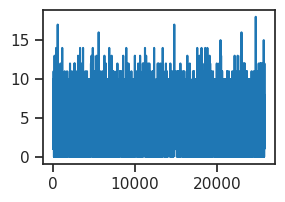

In [32]:
plt.plot(z[:, 17])

In [35]:
phi = tr.model.get_weight('phi')
proj = tr.model.get_weight('proj')
phi_norms = torch.linalg.vector_norm(phi, dim=0)
proj_norms = torch.linalg.vector_norm(proj, dim=0)

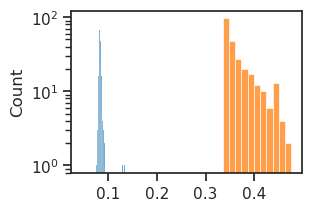

In [36]:
fig, ax = create_figure()
sns.histplot(tonp(phi_norms), color='C0')
sns.histplot(tonp(proj_norms), color='C1')
ax.set_yscale('log');

In [ ]:
log_prior_rate = tr.model.input_layer.log_rate
log_prior_rate = tonp(log_prior_rate.squeeze())
log_prior_rate.shape

In [ ]:
thres = 2
dead = log_prior_rate > thres
dead.sum()

In [45]:
log_prior_rate.min()

-1.5771562

(0.0, 2.1788578093051902)

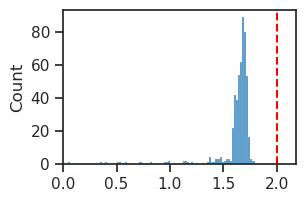

In [46]:
ax = sns.histplot(log_prior_rate)
ax.axvline(thres, ls='--', color='r')
ax.set_xlim(left=0)

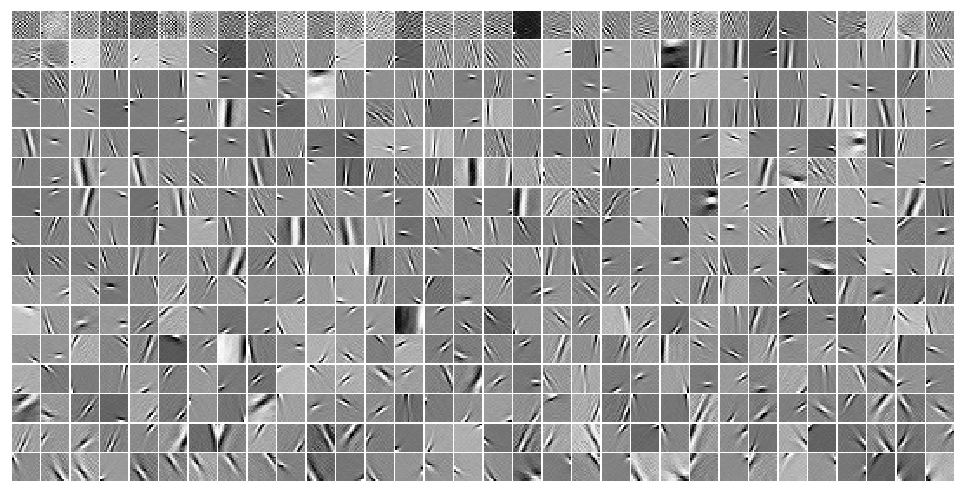

In [47]:
tr.model.show('phi', order=np.argsort(log_prior_rate), dpi=120);

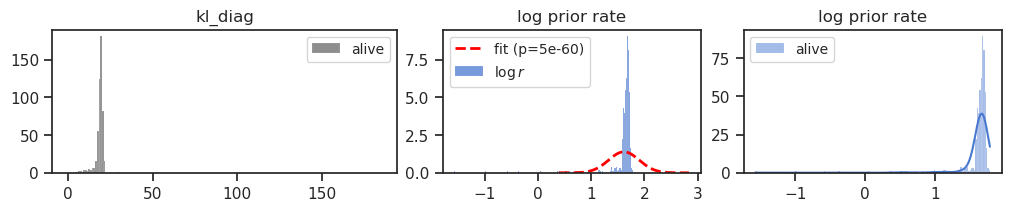

In [50]:
plot_kl_log_rates()

In [51]:
results, _ = fit_loggabor(tr, verbose=True, add_kl=False)

 45%|█████████▍           | 231/512 [00:17<00:08, 31.46it/s]

 73%|███████████████▎     | 372/512 [00:33<00:12, 11.51it/s]

100%|█████████████████████| 512/512 [00:40<00:00, 12.56it/s]


In [52]:
results.loc[results['sf_0'] > 10, 'sf_0'] = np.nan
results.iloc[np.logical_or(dead, np.isnan(results['theta']))] = np.nan

In [66]:
u_test, t_test, cardinal_ratio = perform_test()
print(f"cardinal ratio: {cardinal_ratio:0.3g}\n\n{t_test}\n{u_test}")

cardinal ratio: 0.546

TtestResult(statistic=-0.4747894453581725, pvalue=0.6351516588551265, df=483.0)
MannwhitneyuResult(statistic=14103.0, pvalue=1.217988207483372e-22)

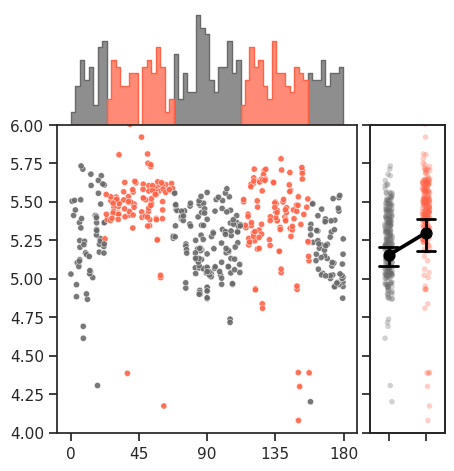

In [67]:
fig, _ = plot_theta(results, ylim_lower=4, ylim_upper=6)

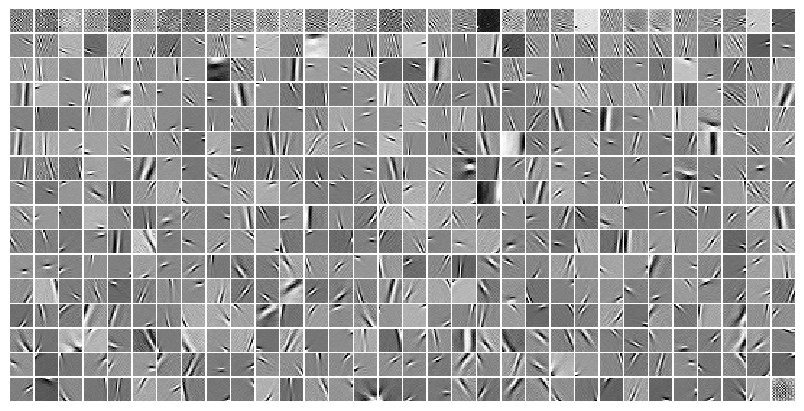

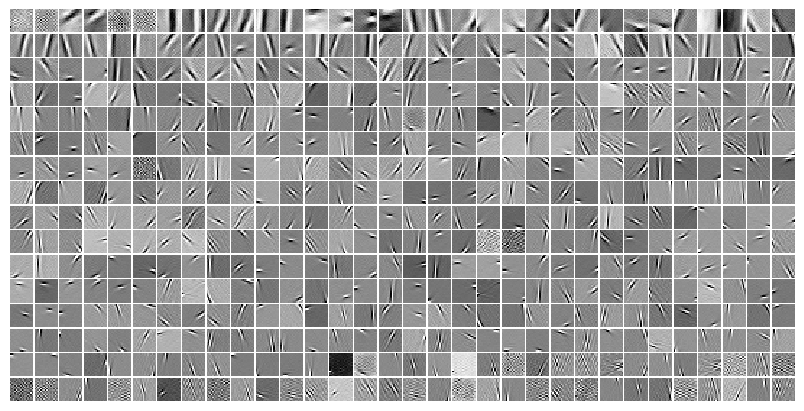

In [69]:
_ = tr.model.show(order=np.argsort(kl_diag[-1]), dpi=100)
_ = tr.model.show(order=np.argsort(results['sf_0'].values), dpi=100)

In [57]:
du_ff_norms = np.linalg.norm(etc['du_ff'], axis=-1)
du_ff_norms.shape

(25811, 10)

In [58]:
du_ff_norms.mean(0)

array([4.751996 , 3.96379  , 3.1913314, 2.6629667, 2.3425438, 2.1496782,
       2.0275512, 1.9421024, 1.8806279, 1.8308938], dtype=float32)

In [61]:
for t in range(tr.model.cfg.seq_len):
    print(t, np.quantile(etc['du_ff'][:, t, :], 0.03), np.quantile(etc['du_ff'][:, t, :], 0.97))

0 -0.41411876678466797 0.4070901870727539

1 -0.36513907432556153 0.2998486232757571

2 -0.2976217269897461 0.23176295280456571

3 -0.24913787841796875 0.18314647674560547

4 -0.2192554473876953 0.15441608428955078

5 -0.20119380950927734 0.1383838653564453

6 -0.18958663940429688 0.12936115264892578

7 -0.18137645721435547 0.12411212921142578

8 -0.17539596557617188 0.12098121643066406

9 -0.17030715942382812 0.11903095245361328

<Axes: ylabel='Count'>

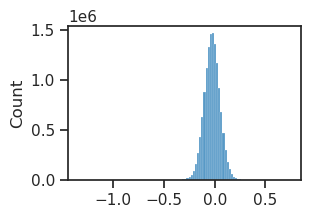

In [63]:
sns.histplot(etc['du_ff'][:, -1, :].ravel(), bins=100)

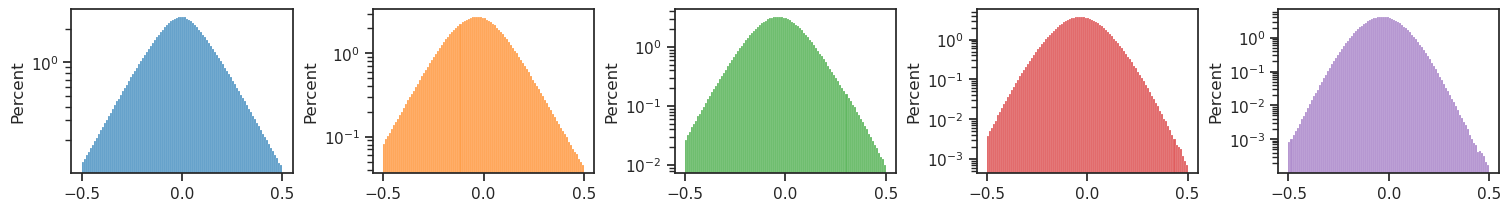

In [60]:
fig, axes = create_figure(1, tr.model.cfg.seq_len)

for t, ax in enumerate(axes.flat):
    sns.histplot(
        etc['du_ff'][:, t, :].ravel(),
        bins=np.linspace(-0.5, 0.5, 101),
        stat='percent',
        color=f'C{t}',
        ax=ax,
    )
    ax.set_yscale('log')
plt.show()

In [98]:
etc['du_ff'][:, t, :].shape

(25811, 512)

In [100]:
etc['du_ff'][:, 0, :].shape

(25811, 512)

In [101]:
np.mean(etc['du_ff'], axis=(0, 2))

array([-0.04114588, -0.04090201, -0.04210081, -0.04333587, -0.04392496],
      dtype=float32)

<Axes: ylabel='Count'>

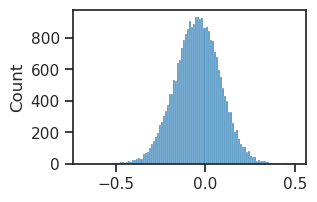

In [111]:
sns.histplot(etc['du_ff'][:, 4, 51])

In [180]:
x = next(iter(tr.dl_vld))[0]
x = x.flatten(start_dim=1).unsqueeze(1)
x = x.expand(-1, vae.cfg.seq_len, -1)

output = vae(x)
len(output)

7

In [182]:
dist, spks, ff, fb, recon, loss_kl, loss_recon = output

In [184]:
ff['T_0']['L_0'].shape

torch.Size([1000, 512])